In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import linalg
import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

In [2]:
n = 20000
c_r = np.linspace(0.1, 2, 100)
eps_c_r = np.exp(np.linspace(np.log(0.1), np.log(2), 10))

pht = np.zeros((100, 10))

In [3]:
for i, c in enumerate(tqdm(c_r)):
    for j, eps_c in enumerate(eps_c_r):
        p = int(np.round(n*c))
        L = int(np.round((n*c*eps_c+1)/2))
        psi = utils.nu(L, 2*np.arange(n)*np.pi/n)
        pht[i, j] = utils.get_pht(n, p, L, tau=psi)

100%|██████████| 100/100 [00:02<00:00, 48.37it/s]


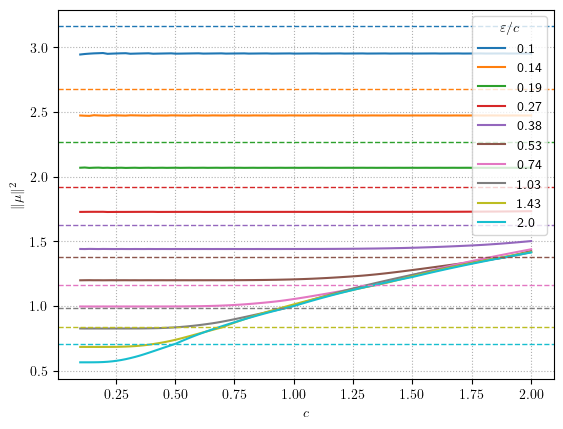

In [4]:
plt.plot(c_r, pht)
xlim = plt.xlim()
for i, eps_c in enumerate(eps_c_r):
    color = 'C'+str(i)
    plt.axhline(y=np.sqrt(1/eps_c), ls='--', lw=1, color=color)
plt.xlim(xlim)
plt.grid(ls=':')
plt.xlabel("$c$")
plt.ylabel("$\\| \\mu \\|^2$")
plt.legend(np.round(eps_c_r, 2), title="$\\varepsilon / c$")
plt.show()

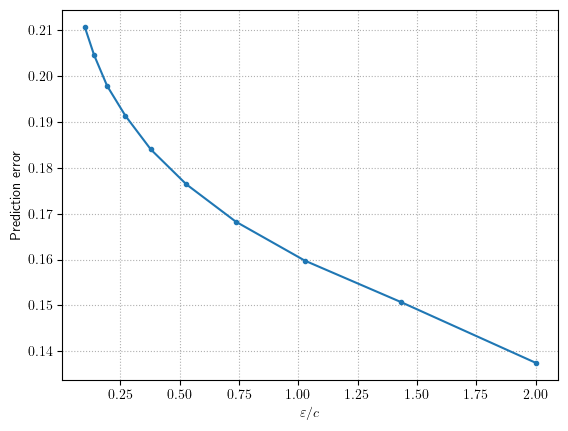

In [5]:
plt.plot(eps_c_r, np.sqrt(1/eps_c_r)-np.mean(pht[:10], axis=0), marker='.')
plt.grid(ls=':')
plt.xlabel("$\\varepsilon / c$")
plt.ylabel("Prediction error")
plt.show()